In [5]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, learning_curve, StratifiedKFold
from sklearn.metrics import precision_recall_curve, plot_precision_recall_curve
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn import tree
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import AdaBoostClassifier,BaggingClassifier,GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, plot_roc_curve
from sklearn.svm import SVC

In [6]:
df = pd.read_csv('water_potability.csv')
df.columns = ['ph', 'Hardness', 'Solids', 'Chloramines', 'Sulfate', 'Conductivity', 'Organic_carbon', 'Trihalomethanes', 'Turbidity', 'Potability']
df.head()
df.isnull().sum()

ph                 491
Hardness             0
Solids               0
Chloramines          0
Sulfate            781
Conductivity         0
Organic_carbon       0
Trihalomethanes    162
Turbidity            0
Potability           0
dtype: int64

In [7]:
#Replace null values based on the group/sample mean

df['ph']=df['ph'].fillna(df.groupby(['Potability'])['ph'].transform('mean'))
df['Sulfate']=df['Sulfate'].fillna(df.groupby(['Potability'])['Sulfate'].transform('mean'))
df['Trihalomethanes']=df['Trihalomethanes'].fillna(df.groupby(['Potability'])['Trihalomethanes'].transform('mean'))

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3276 entries, 0 to 3275
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   ph               3276 non-null   float64
 1   Hardness         3276 non-null   float64
 2   Solids           3276 non-null   float64
 3   Chloramines      3276 non-null   float64
 4   Sulfate          3276 non-null   float64
 5   Conductivity     3276 non-null   float64
 6   Organic_carbon   3276 non-null   float64
 7   Trihalomethanes  3276 non-null   float64
 8   Turbidity        3276 non-null   float64
 9   Potability       3276 non-null   int64  
dtypes: float64(9), int64(1)
memory usage: 256.1 KB


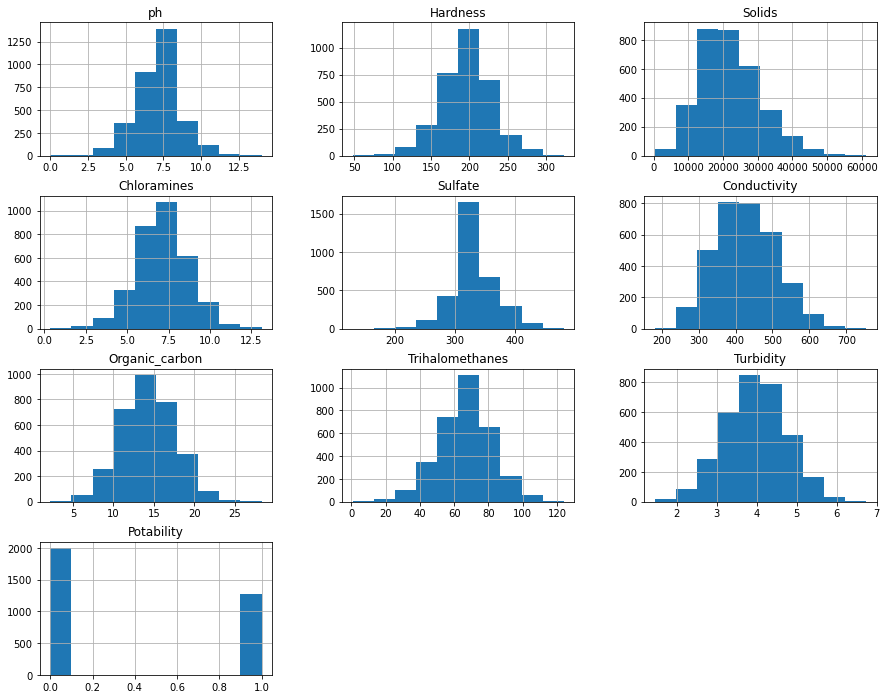

In [9]:
df.hist(bins=10,figsize=(15,12))
plt.show()

<AxesSubplot:>

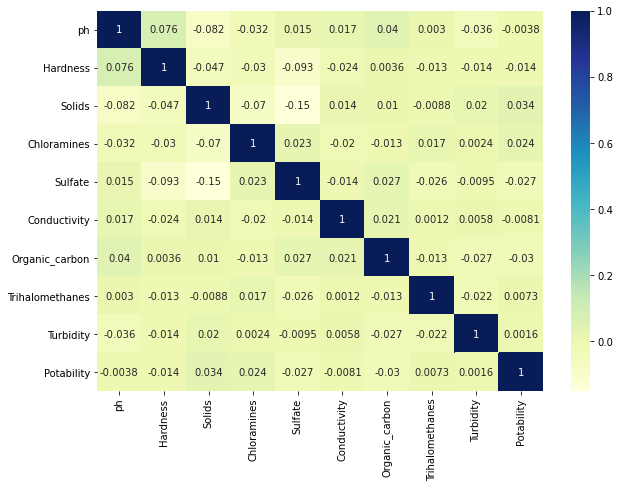

In [10]:
plt.figure(figsize = (10,7))
sns.heatmap(df.corr(), cmap="YlGnBu", annot = True)

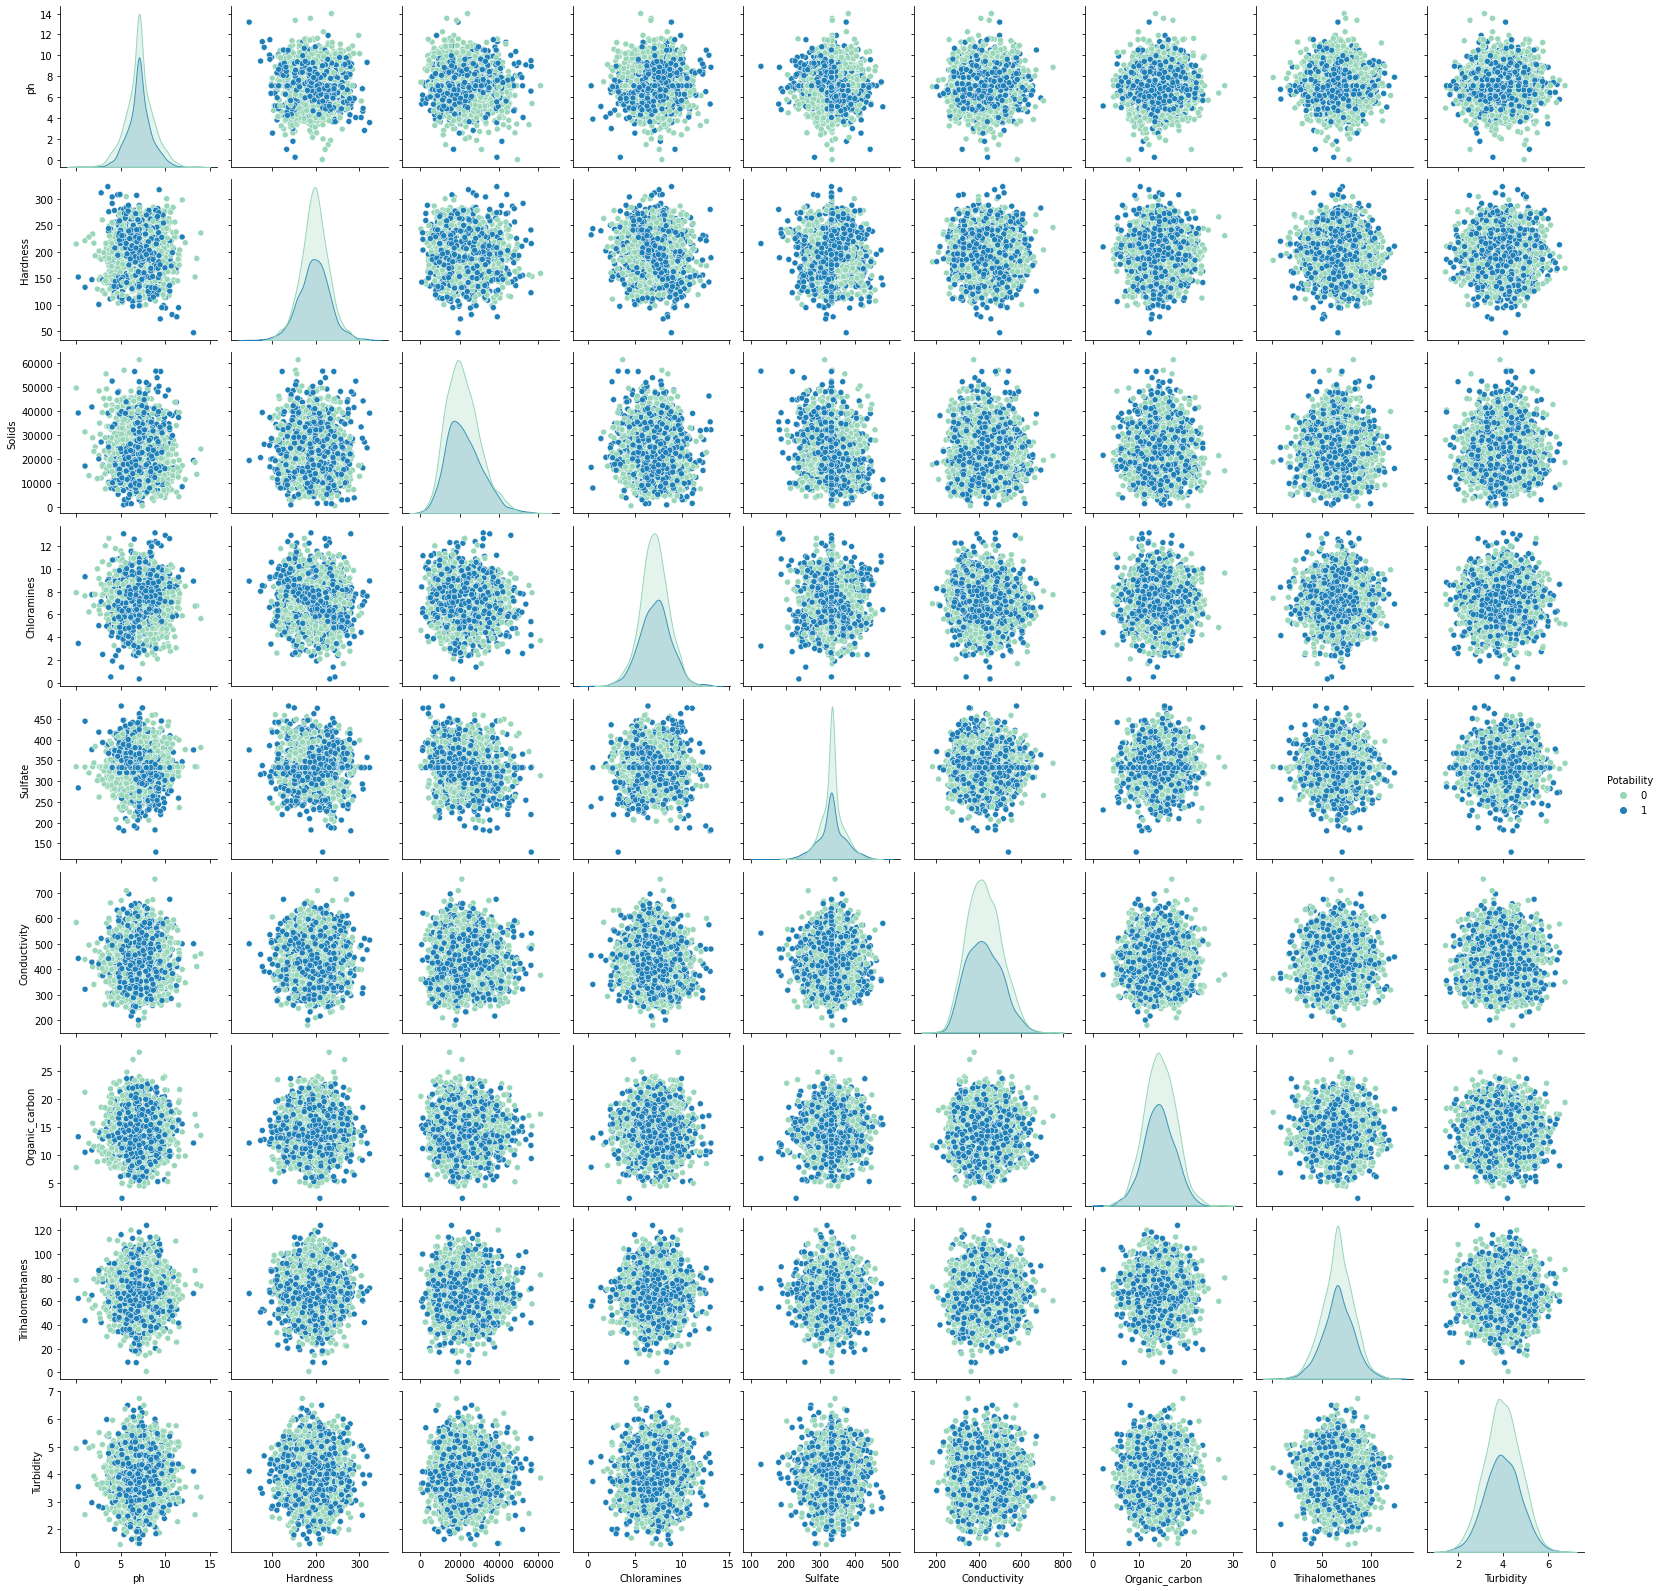

In [11]:
ax = sns.pairplot(df, hue="Potability",diag_kind="kde",kind="scatter",palette="YlGnBu")
plt.show()

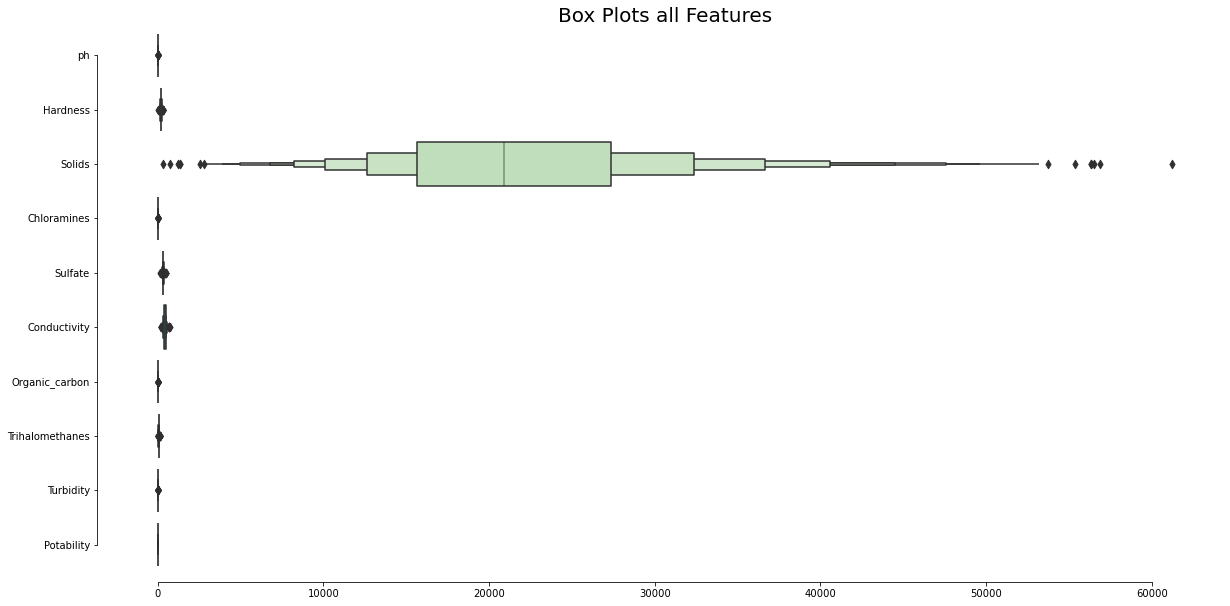

In [12]:
fig1, ax = plt.subplots(figsize=[20,10])
ax = sns.boxenplot(data=df, orient="h", palette="YlGnBu")
sns.despine(offset=10, trim=True)
plt.title("Box Plots all Features", fontsize=20);
plt.show()

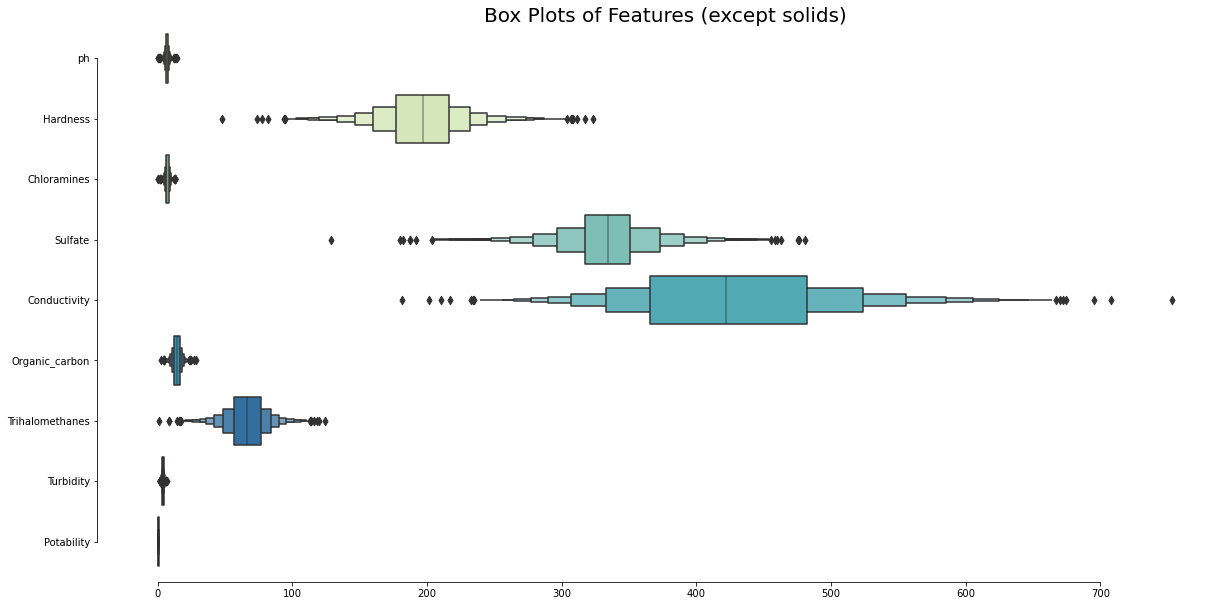

In [13]:
df1 = pd.DataFrame()
df1 = df
df1 = df1.drop("Solids",1)
fig1, ax = plt.subplots(figsize=[20,10])
ax = sns.boxenplot(data=df1, orient="h", palette="YlGnBu")
sns.despine(offset=10, trim=True)
plt.title("Box Plots of Features (except solids)", fontsize=20);
plt.show()

<AxesSubplot:xlabel='Potability', ylabel='count'>

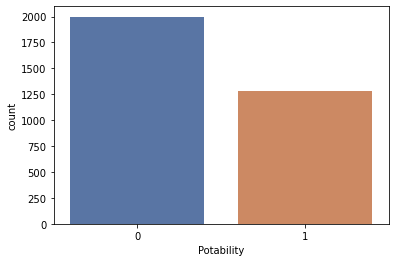

In [14]:
sns.countplot(x='Potability', data=df, palette="deep")

In [15]:
X = df.drop(['Potability'], axis = 1)
y = df['Potability']

In [16]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size = 0.25, random_state = 42, stratify = y)

In [17]:
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_val = sc.transform(X_val)

In [18]:
cv = StratifiedKFold(n_splits=5)

# Decision Tree

In [19]:
dtc = DecisionTreeClassifier(min_samples_split=7,random_state=42)
dtc.fit(X_train, y_train)

y_pred_dtc = dtc.predict(X_val)

score = dtc.score(X_val, y_val)
print(score)

0.724053724053724


In [20]:
print(classification_report(y_val, y_pred_dtc))

              precision    recall  f1-score   support

           0       0.78      0.76      0.77       500
           1       0.64      0.66      0.65       319

    accuracy                           0.72       819
   macro avg       0.71      0.71      0.71       819
weighted avg       0.73      0.72      0.72       819



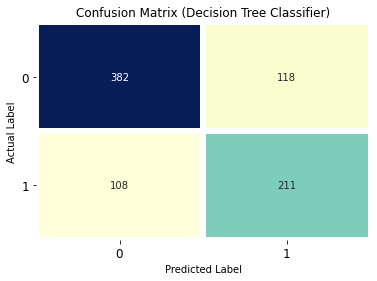

In [21]:
plt.figure(figsize= (6,4))
sns.heatmap(confusion_matrix(y_val, y_pred_dtc), cmap="YlGnBu", annot=True, fmt= 'd', linewidths = 5, cbar = False)
plt.xlabel("Predicted Label")
plt.xticks(size = 12)
plt.yticks(size = 12, rotation = 0)
plt.ylabel("Actual Label")
plt.title("Confusion Matrix (Decision Tree Classifier)", size = 12)
plt.show()

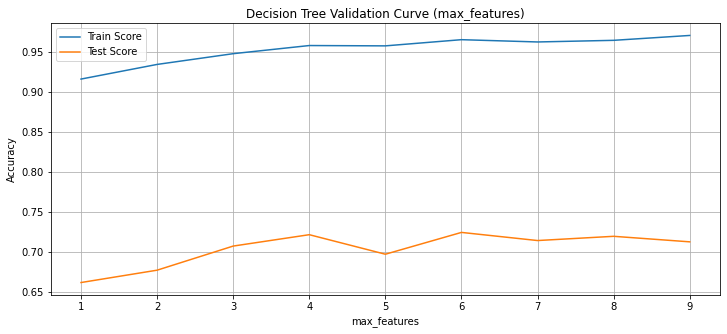

In [22]:
dtc_mf_test_scores = []
dtc_mf_train_scores = []

for i in range(1,10):

    dtc_mf = DecisionTreeClassifier(min_samples_split=7, max_features = i, random_state=42)
    dtc_mf.fit(X_train,y_train)
    
    dtc_mf_train_scores.append(dtc_mf.score(X_train,y_train))
    dtc_mf_test_scores.append(cross_val_score(dtc_mf, X_train,y_train, cv=cv).mean())

plt.figure(figsize=(12,5))
plt.title("Decision Tree Validation Curve (max_features)")
plt.xlabel("max_features")
plt.ylabel("Accuracy")
plt.plot(range(1,10),dtc_mf_train_scores,marker='',label='Train Score')
plt.plot(range(1,10),dtc_mf_test_scores,marker='',label='Test Score')
plt.grid()
plt.legend(loc="best")

In [23]:
dtc_mf_max_test_score = max(dtc_mf_test_scores)
dtc_mf_test_scores_ind = [i for i, v in enumerate(dtc_mf_test_scores) if v == dtc_mf_max_test_score]
print('Max test score {} % and max_features = {}'.format(dtc_mf_max_test_score*100,list(map(lambda x: x+1, dtc_mf_test_scores_ind))))

Max test score 72.40458331263557 % and max_features = [6]


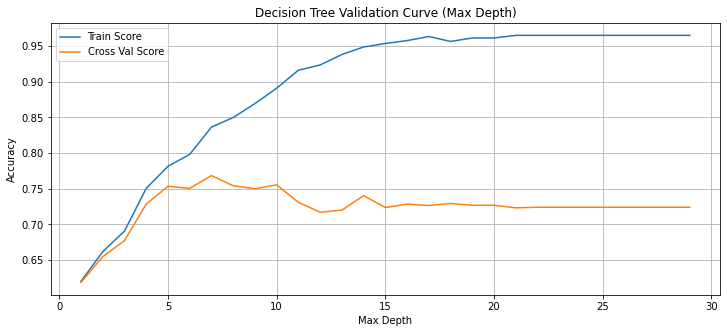

In [24]:
dtc1_test_scores = []
dtc1_train_scores = []

for i in range(1,30):

    dtc_md = DecisionTreeClassifier(max_depth=i,max_features=6,random_state=42,min_samples_split=7)
    dtc_md.fit(X_train,y_train)
    
    dtc1_train_scores.append(dtc_md.score(X_train,y_train))
    dtc1_test_scores.append(cross_val_score(dtc_md, X_train,y_train, cv=cv).mean())

plt.figure(figsize=(12,5))
plt.title("Decision Tree Validation Curve (Max Depth)")
plt.xlabel("Max Depth")
plt.ylabel("Accuracy")
plt.plot(range(1,30),dtc1_train_scores,marker='',label='Train Score')
plt.plot(range(1,30),dtc1_test_scores,marker='',label='Cross Val Score')
plt.grid()
plt.legend(loc="best")

In [25]:
dtc1_max_test_score = max(dtc1_test_scores)
dtc1_test_scores_ind = [i for i, v in enumerate(dtc1_test_scores) if v == dtc1_max_test_score]
print('Max test score {} % and max depth = {}'.format(dtc1_max_test_score*100,list(map(lambda x: x+1, dtc1_test_scores_ind))))

Max test score 76.84168695047438 % and max depth = [7]


In [26]:
dtc_final = DecisionTreeClassifier(max_depth=7, min_samples_split=7, max_features = 6, random_state=42)
dtc_final.fit(X_train, y_train)

y_pred_final_dtc = dtc_final.predict(X_val)

dtc_final_score = dtc_final.score(X_val, y_val)
print(dtc_final_score)

0.7680097680097681


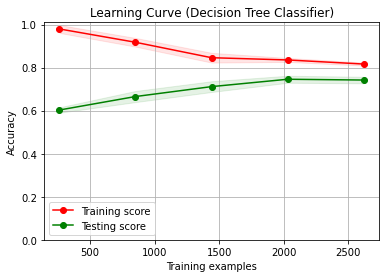

In [27]:
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=cv,
                        n_jobs=1, train_sizes=np.linspace(.1, 1.0, 5)):

    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Accuracy")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Testing score")

    plt.legend(loc="best")
    return plt

X = X
y = y
title = "Learning Curve (Decision Tree Classifier)"
cv = cv
estimator = dtc_final

plot_learning_curve(estimator, title, X, y, ylim=(0, 1.01), cv=cv, n_jobs=1)
plt.show()

In [28]:
print(classification_report(y_val, y_pred_final_dtc))

              precision    recall  f1-score   support

           0       0.77      0.89      0.82       500
           1       0.77      0.58      0.66       319

    accuracy                           0.77       819
   macro avg       0.77      0.73      0.74       819
weighted avg       0.77      0.77      0.76       819



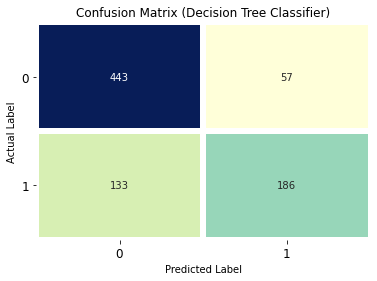

In [29]:
plt.figure(figsize= (6,4))
sns.heatmap(confusion_matrix(y_val, y_pred_final_dtc), cmap="YlGnBu", annot=True, fmt= 'd', linewidths = 5, cbar = False)
plt.xlabel("Predicted Label")
plt.xticks(size = 12)
plt.yticks(size = 12, rotation = 0)
plt.ylabel("Actual Label")
plt.title("Confusion Matrix (Decision Tree Classifier)", size = 12)
plt.show()

Text(0.5, 1.0, 'ROC Curve (Decision Tree Classifier)')

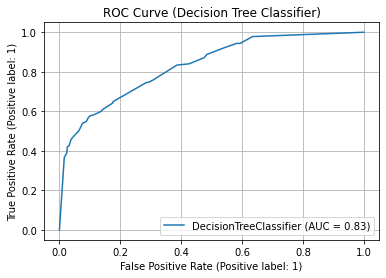

In [30]:
dtc_plot = plot_roc_curve(dtc_final, X_val, y_val)
plt.grid()
plt.title("ROC Curve (Decision Tree Classifier)")

Text(0.5, 1.0, 'Precision Recall Curve (Decision Tree Classifier)')

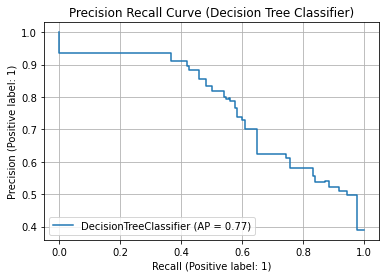

In [31]:
plot_precision_recall_curve(dtc_final, X_val, y_val)
plt.grid()
plt.title("Precision Recall Curve (Decision Tree Classifier)")

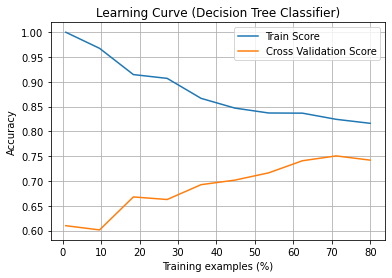

In [54]:
dtc_final3 = DecisionTreeClassifier(max_depth=7, min_samples_split=7, max_features = 6, random_state=42)

train_sizes, train_scores, test_scores = learning_curve(dtc_final3, X, y, cv = cv, scoring = 'accuracy', train_sizes=np.linspace(0.01,1,10))

train_mean = np.mean(train_scores, axis = 1)
test_mean = np.mean(test_scores, axis = 1)


plt.title("Learning Curve (Decision Tree Classifier)")
plt.xlabel("Training examples (%)")
plt.ylabel("Accuracy")
plt.plot(train_sizes/len(X)*100, train_mean, label='Train Score')
plt.plot(train_sizes/len(X)*100, test_mean, label='Cross Validation Score')
plt.legend(loc="best")
plt.grid()
plt.show()

# KNN

In [32]:
knn = KNeighborsClassifier(n_neighbors=5) 
knn.fit(X_train, y_train)
y_pred_knn = knn.predict(X_val) 
print(classification_report(y_val, y_pred_knn))

              precision    recall  f1-score   support

           0       0.66      0.81      0.73       500
           1       0.54      0.35      0.42       319

    accuracy                           0.63       819
   macro avg       0.60      0.58      0.58       819
weighted avg       0.61      0.63      0.61       819



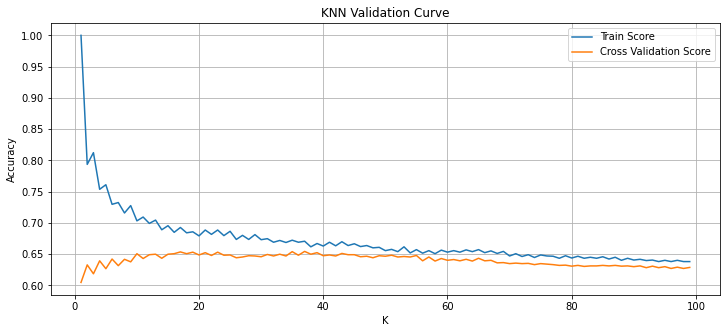

In [52]:
knn_wu_test_scores = []
knn_wu_train_scores = []

for i in range(1,100):

    knn_wu = KNeighborsClassifier(weights = 'uniform', n_neighbors=i, algorithm='kd_tree')
    knn_wu.fit(X_train,y_train)
    
    knn_wu_train_scores.append(knn_wu.score(X_train,y_train))
    knn_wu_test_scores.append(cross_val_score(knn_wu, X_train,y_train, cv=cv).mean())

plt.figure(figsize=(12,5))
plt.title("KNN Validation Curve")
plt.xlabel("K")
plt.ylabel("Accuracy")
plt.plot(range(1,100),knn_wu_train_scores,marker='',label='Train Score')
plt.plot(range(1,100),knn_wu_test_scores,marker='',label='Cross Validation Score')
plt.grid()
plt.legend(loc="best")

In [34]:
knn_wu_max_test_score = max(knn_wu_test_scores)
knn_wu_test_scores_ind = [i for i, v in enumerate(knn_wu_test_scores) if v == knn_wu_max_test_score]
print('Max test score {} % and k = {}'.format(knn_wu_max_test_score*100,list(map(lambda x: x+1, knn_wu_test_scores_ind))))

Max test score 65.4450019041942 % and k = [37]


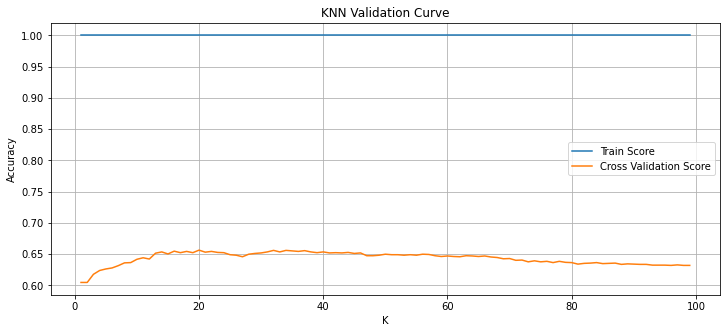

In [51]:
knn_kv_test_scores = []
knn_kv_train_scores = []

for i in range(1,100):

    knn_kv = KNeighborsClassifier(weights = 'distance', n_neighbors=i, algorithm='kd_tree')
    knn_kv.fit(X_train,y_train)
    
    knn_kv_train_scores.append(knn_kv.score(X_train,y_train))
    knn_kv_test_scores.append(cross_val_score(knn_kv, X_train,y_train, cv=cv).mean())

plt.figure(figsize=(12,5))
plt.title("KNN Validation Curve")
plt.xlabel("K")
plt.ylabel("Accuracy")
plt.plot(range(1,100),knn_kv_train_scores,marker='',label='Train Score')
plt.plot(range(1,100),knn_kv_test_scores,marker='',label='Cross Validation Score')
plt.grid()
plt.legend(loc="best")

In [36]:
knn_kv_max_test_score = max(knn_kv_test_scores)
knn_kv_test_scores_ind = [i for i, v in enumerate(knn_kv_test_scores) if v == knn_kv_max_test_score]
print('Max test score {} % and k = {}'.format(knn_kv_max_test_score*100,list(map(lambda x: x+1, knn_kv_test_scores_ind))))

Max test score 65.64800556355867 % and k = [20]


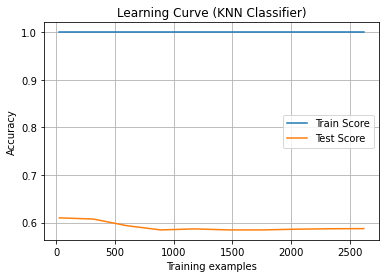

In [37]:
train_sizes, train_scores, test_scores = learning_curve(KNeighborsClassifier(weights = 'distance', n_neighbors = 20), X, y, cv = 5, scoring = 'accuracy', train_sizes=np.linspace(0.01,1,10))

train_mean = np.mean(train_scores, axis = 1)
train_mean

test_mean = np.mean(test_scores, axis = 1)
test_mean

train_sizes

plt.plot(train_sizes, train_mean, label='Train Score')
plt.plot(train_sizes, test_mean, label='Test Score')
plt.grid()
plt.title("Learning Curve (KNN Classifier)")
plt.xlabel("Training examples")
plt.ylabel("Accuracy")
plt.legend(loc="best")

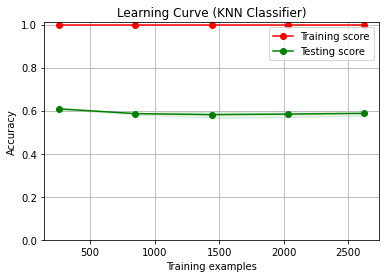

In [38]:
X = X
y = y
title = "Learning Curve (KNN Classifier)"
cv = cv
estimator = KNeighborsClassifier(weights = 'distance', n_neighbors = 20)

plot_learning_curve(estimator, title, X, y, ylim=(0, 1.01), cv=cv, n_jobs=1)
plt.show()

In [39]:
knn_final = KNeighborsClassifier(weights = 'distance', n_neighbors = 20)
knn_final.fit(X_train, y_train)
y_pred_knn_final = knn_final.predict(X_val)
score_final = knn_final.score(X_val, y_val)

print(score_final)

0.645909645909646


In [40]:
print(classification_report(y_val, y_pred_knn))

              precision    recall  f1-score   support

           0       0.66      0.81      0.73       500
           1       0.54      0.35      0.42       319

    accuracy                           0.63       819
   macro avg       0.60      0.58      0.58       819
weighted avg       0.61      0.63      0.61       819



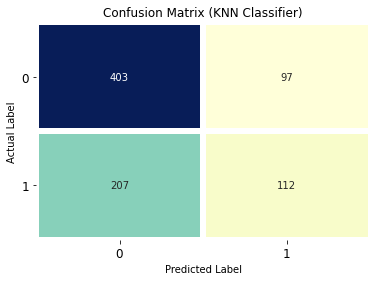

In [41]:
plt.figure(figsize= (6,4))
sns.heatmap(confusion_matrix(y_val, y_pred_knn), cmap="YlGnBu", annot=True, fmt= 'd', linewidths = 5, cbar = False)
plt.xlabel("Predicted Label")
plt.xticks(size = 12)
plt.yticks(size = 12, rotation = 0)
plt.ylabel("Actual Label")
plt.title("Confusion Matrix (KNN Classifier)", size = 12)
plt.show()

Text(0.5, 1.0, 'ROC Curve (KNN Classifier)')

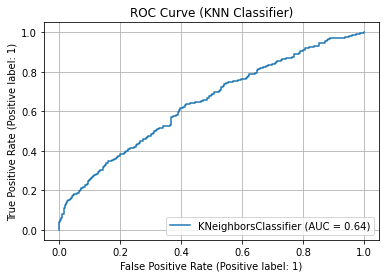

In [42]:
knn_roc_plot = plot_roc_curve(knn_final, X_val, y_val)
plt.grid()
plt.title("ROC Curve (KNN Classifier)")

Text(0.5, 1.0, 'Precision Recall Curve (KNN Classifier)')

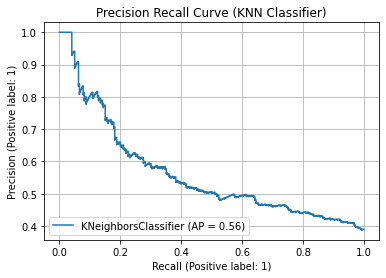

In [43]:
plot_precision_recall_curve(knn_final, X_val, y_val)
plt.grid()
plt.title("Precision Recall Curve (KNN Classifier)")

# SVC

In [44]:
svc = SVC(kernel='rbf',C=1)
svc.fit(X_train, y_train)
y_pred_svc = svc.predict(X_val)

score = svc.score(X_val, y_val)
print(score)

0.6691086691086691


In [55]:
svc = SVC(kernel='linear',C=1)
svc.fit(X_train, y_train)
y_pred_svc = svc.predict(X_val)

score = svc.score(X_val, y_val)
print(score)

0.6105006105006106


In [56]:
print(classification_report(y_val, y_pred_svc))

              precision    recall  f1-score   support

           0       0.61      1.00      0.76       500
           1       0.00      0.00      0.00       319

    accuracy                           0.61       819
   macro avg       0.31      0.50      0.38       819
weighted avg       0.37      0.61      0.46       819



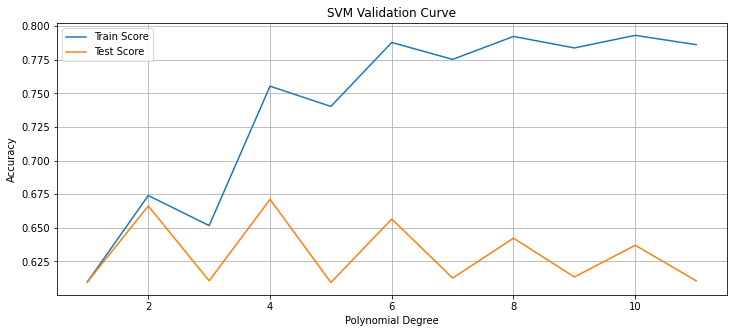

In [46]:
svc_test_scores = []
svc_train_scores = []

for i in range(1,12):

    svc_p = SVC(kernel="poly", degree=i, random_state=42)
    svc_p.fit(X_train,y_train)
    
    svc_train_scores.append(svc_p.score(X_train,y_train))
    svc_test_scores.append(cross_val_score(svc_p, X_train,y_train, cv=cv).mean())

plt.figure(figsize=(12,5))
plt.title("SVM Validation Curve")
plt.xlabel("Polynomial Degree")
plt.ylabel("Accuracy")
plt.plot(range(1,12),svc_train_scores,marker='',label='Train Score')
plt.plot(range(1,12),svc_test_scores,marker='',label='Test Score')
plt.grid()
plt.legend(loc="best")

In [47]:
svc_max_test_score = max(svc_test_scores)
svc_test_scores_ind = [i for i, v in enumerate(svc_test_scores) if v == svc_max_test_score]
print('Max test score {} % and k = {}'.format(svc_max_test_score*100,list(map(lambda x: x+1, svc_test_scores_ind))))

Max test score 67.11357276505557 % and k = [4]


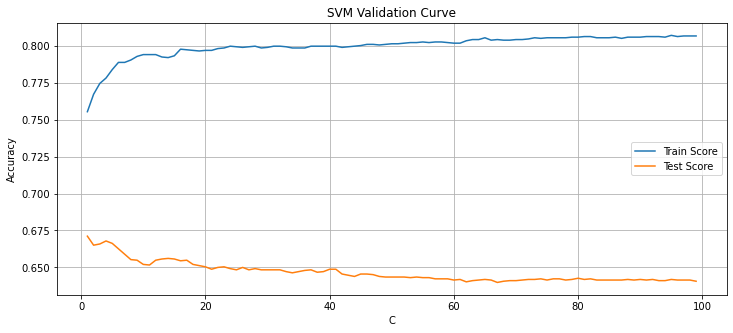

In [48]:
svc_c_test_scores = []
svc_c_train_scores = []

for i in range(1,100):

    svc_c = SVC(kernel="poly", degree=4, C=i, random_state=42)
    svc_c.fit(X_train,y_train)
    
    svc_c_train_scores.append(svc_c.score(X_train,y_train))
    svc_c_test_scores.append(cross_val_score(svc_c, X_train,y_train, cv=cv).mean())

plt.figure(figsize=(12,5))
plt.title("SVM Validation Curve")
plt.xlabel("C")
plt.ylabel("Accuracy")
plt.plot(range(1,100),svc_c_train_scores,marker='',label='Train Score')
plt.plot(range(1,100),svc_c_test_scores,marker='',label='Test Score')
plt.grid()
plt.legend(loc="best")

In [57]:
svc_c_max_test_score = max(svc_c_test_scores)
svc_c_test_scores_ind = [i for i, v in enumerate(svc_c_test_scores) if v == svc_c_max_test_score]
print('Max test score {} % and C = {}'.format(svc_c_max_test_score*100,list(map(lambda x: x+1, svc_c_test_scores_ind))))

Max test score 67.11357276505557 % and C = [1]


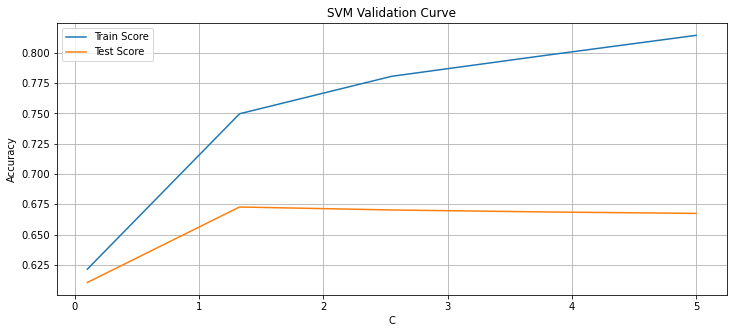

In [59]:
svc_rc_test_scores = []
svc_rc_train_scores = []

for i in np.linspace(0.1, 5, 5):

    svc_rc = SVC(kernel="rbf", C=i, random_state=42)
    svc_rc.fit(X_train,y_train)
    
    svc_rc_train_scores.append(svc_rc.score(X_train,y_train))
    svc_rc_test_scores.append(cross_val_score(svc_rc, X_train,y_train, cv=cv).mean())

plt.figure(figsize=(12,5))
plt.title("SVM Validation Curve")
plt.xlabel("C")
plt.ylabel("Accuracy")
plt.plot(np.linspace(0.1, 5, 5),svc_rc_train_scores,marker='',label='Train Score')
plt.plot(np.linspace(0.1, 5, 5),svc_rc_test_scores,marker='',label='Test Score')
plt.grid()
plt.legend(loc="best")

In [1]:
svc_rc_max_test_score = max(svc_rc_test_scores)
svc_rc_test_scores_ind = [i for i, v in enumerate(svc_rc_test_scores) if v == svc_rc_max_test_score]
print('Max test score {} % and C = {}'.format(svc_rc_max_test_score*100,list(map(lambda x: x+1, svc_rc_test_scores_ind))))

NameError: name 'svc_rc_test_scores' is not defined

In [63]:
test_scores = []
train_scores = []

for i in range(1,400):

    svc_p = SVC(kernel="rbf", c=1, max_iter=i)
    svc_p.fit(X_train,y_train)
    
    train_scores.append(svc_p.score(X_train,y_train))
    test_scores.append(svc_p.score(X_val,y_val))

plt.figure(figsize=(12,5))
plt.title("SVM Loss Curve")
plt.xlabel("Max Iterations")
plt.ylabel("Accuracy")
plt.plot(range(1,400),train_scores,marker='',label='Train Score')
plt.plot(range(1,400),test_scores,marker='',label='Test Score')
plt.grid()
plt.legend(loc="best")

TypeError: __init__() got an unexpected keyword argument 'c'

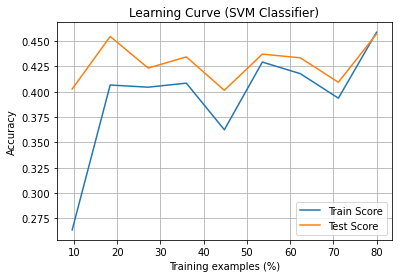

In [61]:
train_sizes, train_scores, test_scores = learning_curve(SVC(kernel="rbf", C=1, max_iter=25), X, y, cv = cv, scoring = 'accuracy', train_sizes=np.linspace(0.01,1,10))

train_mean = np.mean(train_scores, axis = 1)
train_mean

test_mean = np.mean(test_scores, axis = 1)
test_mean

train_sizes

plt.plot(train_sizes/len(X)*100, train_mean, label='Train Score')
plt.plot(train_sizes/len(X)*100, test_mean, label='Test Score')
plt.grid()
plt.title("Learning Curve (SVM Classifier)")
plt.xlabel("Training examples (%)")
plt.ylabel("Accuracy")
plt.legend(loc="best")

# Boosting

In [123]:
ada=AdaBoostClassifier(dtc_final, random_state=42)
ada.fit(X_train,y_train)
y_pred_ada=ada.predict(X_val)
score = ada.score(X_val, y_val)

print(score)

0.7032967032967034


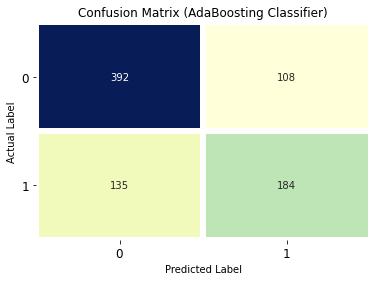

In [124]:
plt.figure(figsize= (6,4))
sns.heatmap(confusion_matrix(y_val, y_pred_ada), cmap="YlGnBu", annot=True, fmt= 'd', linewidths = 5, cbar = False)
plt.xlabel("Predicted Label")
plt.xticks(size = 12)
plt.yticks(size = 12, rotation = 0)
plt.ylabel("Actual Label")
plt.title("Confusion Matrix (AdaBoosting Classifier)", size = 12)
plt.show()

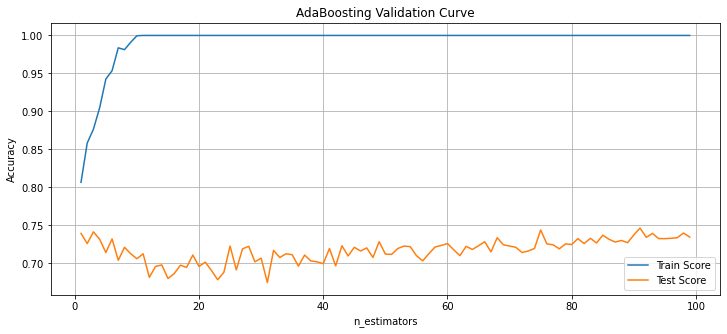

In [126]:
ada_ne_test_scores = []
ada_ne_train_scores = []

for i in range(1,100):
    
    ada_vc = AdaBoostClassifier(dtc_final, n_estimators=i)
    ada_vc.fit(X_train,y_train)
    
    ada_ne_train_scores.append(ada_vc.score(X_train,y_train))
    ada_ne_test_scores.append(cross_val_score(ada_vc, X_train,y_train, cv=cv).mean())

plt.figure(figsize=(12,5))
plt.title("AdaBoosting Validation Curve")
plt.xlabel("n_estimators")
plt.ylabel("Accuracy")
plt.plot(range(1,100),ada_ne_train_scores,marker='',label='Train Score')
plt.plot(range(1,100),ada_ne_test_scores,marker='',label='Test Score')
plt.grid()
plt.legend(loc="best")

In [127]:
ada_ne_max_test_score = max(ada_ne_test_scores)
ada_ne_test_scores_ind = [i for i, v in enumerate(ada_ne_test_scores) if v == ada_ne_max_test_score]
print('Max test score {} % and n_estimators = {}'.format(ada_ne_max_test_score*100,list(map(lambda x: x+1, ada_ne_test_scores_ind))))

Max test score 74.64366731243686 % and n_estimators = [91]


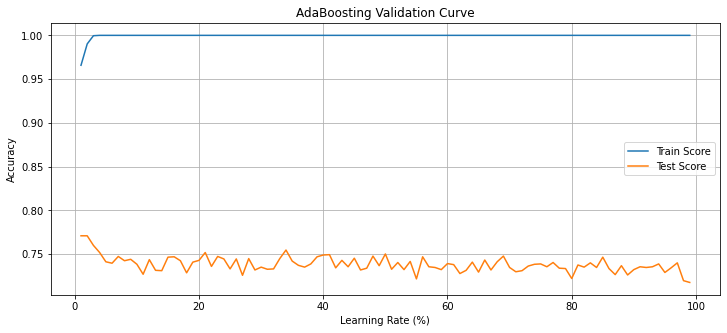

In [130]:
ada_lr_test_scores = []
ada_lr_train_scores = []

for i in range(1,100):
    
    i = i/100
    
    ada_vc2 = AdaBoostClassifier(dtc_final, n_estimators=91,learning_rate = i)
    ada_vc2.fit(X_train,y_train)
    
    ada_lr_train_scores.append(ada_vc2.score(X_train,y_train))
    ada_lr_test_scores.append(cross_val_score(ada_vc2, X_train,y_train, cv=cv).mean())

plt.figure(figsize=(12,5))
plt.title("AdaBoosting Validation Curve")
plt.xlabel("Learning Rate (%)")
plt.ylabel("Accuracy")
plt.plot(range(1,100),ada_lr_train_scores,marker='',label='Train Score')
plt.plot(range(1,100),ada_lr_test_scores,marker='',label='Test Score')
plt.grid()
plt.legend(loc="best")

In [131]:
ada_lr_max_test_score = max(ada_lr_test_scores)
ada_lr_test_scores_ind = [i for i, v in enumerate(ada_lr_test_scores) if v == ada_lr_max_test_score]
print('Max test score {} % and learning_rate = {}'.format(ada_lr_max_test_score*100,list(map(lambda x: x+1, ada_lr_test_scores_ind))))

Max test score 77.08625171791432 % and learning_rate = [1]


In [ ]:
DecisionTreeClassifier(max_depth=7, min_samples_split=7, max_features = 6, random_state=42)

In [136]:
ada_p_test_scores = []
ada_p_train_scores = []
DecisionTreeClassifier(max_depth=7, min_samples_split=7, max_features = 6, random_state=42)

for i in range(1,51):
    i = i/100
    
    dtc_final2 = DecisionTreeClassifier(max_depth=7, min_samples_split=7, max_features = 6, min_weight_fraction_leaf = i, random_state=42)
    
    ada_p = AdaBoostClassifier(dtc_final2, n_estimators=91,learning_rate = 0.01)
    ada_p.fit(X_train,y_train)
    
    ada_p_train_scores.append(ada_p.score(X_train,y_train))
    ada_p_test_scores.append(cross_val_score(ada_p, X_train,y_train, cv=cv).mean())


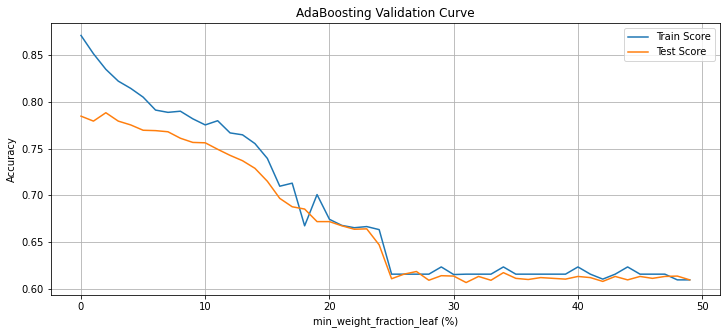

In [138]:
plt.figure(figsize=(12,5))
plt.title("AdaBoosting Validation Curve")
plt.xlabel("min_weight_fraction_leaf (%)")
plt.ylabel("Accuracy")
plt.plot(ada_p_train_scores,marker='',label='Train Score')
plt.plot(ada_p_test_scores,marker='',label='Test Score')
plt.grid()
plt.legend(loc="best")

In [140]:
ada_p_max_test_score = max(ada_p_test_scores)
ada_p_test_scores_ind = [i for i, v in enumerate(ada_p_test_scores) if v == ada_p_max_test_score]
print('Max test score {} % and learning_rate = {}'.format(ada_p_max_test_score*100,list(map(lambda x: x+1, ada_p_test_scores_ind))))

Max test score 78.83620618283577 % and min_weight_fraction_leaf (%) = [3]


In [65]:
dtc_final2 = DecisionTreeClassifier(max_depth=7, min_samples_split=7, max_features = 6, min_weight_fraction_leaf=0.03, random_state=42)
ada_final = AdaBoostClassifier(dtc_final2, n_estimators=91,learning_rate = 0.01, random_state=42)
ada_final.fit(X_train,y_train)
y_pred_ada_final=ada_final.predict(X_val)
score = ada_final.score(X_val, y_val)

print(score)

0.778998778998779


In [66]:
print(classification_report(y_val,y_pred_ada_final))

              precision    recall  f1-score   support

           0       0.77      0.91      0.83       500
           1       0.80      0.58      0.67       319

    accuracy                           0.78       819
   macro avg       0.78      0.74      0.75       819
weighted avg       0.78      0.78      0.77       819



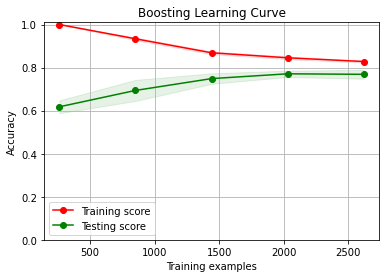

In [145]:
plot_learning_curve(ada_final, "Boosting Learning Curve", X, y, ylim=(0, 1.01), cv=cv, n_jobs=1)
plt.show()

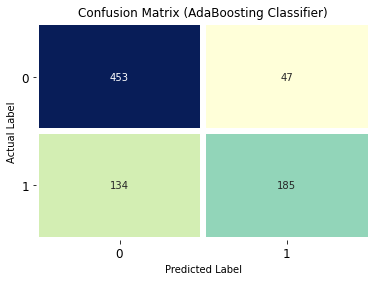

In [146]:
plt.figure(figsize= (6,4))
sns.heatmap(confusion_matrix(y_val, y_pred_ada_final), cmap="YlGnBu", annot=True, fmt= 'd', linewidths = 5, cbar = False)
plt.xlabel("Predicted Label")
plt.xticks(size = 12)
plt.yticks(size = 12, rotation = 0)
plt.ylabel("Actual Label")
plt.title("Confusion Matrix (AdaBoosting Classifier)", size = 12)
plt.show()

Text(0.5, 1.0, 'ROC Curve (AdaBoosting Classifier)')

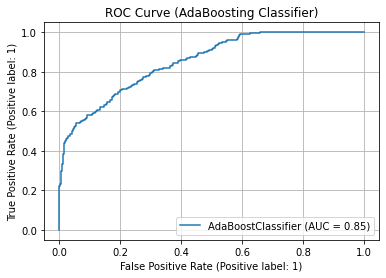

In [147]:
ada_roc_plot = plot_roc_curve(ada_final, X_val, y_val)
plt.grid()
plt.title("ROC Curve (AdaBoosting Classifier)")

Text(0.5, 1.0, 'Precision Recall Curve (AdaBoosting Classifier)')

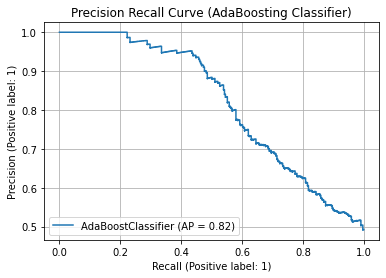

In [148]:
plot_precision_recall_curve(ada_final, X_val, y_val)
plt.grid()
plt.title("Precision Recall Curve (AdaBoosting Classifier)")

# ANN

In [239]:
mlp=MLPClassifier(solver='sgd', max_iter=200)
mlp.fit(X_train,y_train)
y_pred_mlp=mlp.predict(X_val)

In [240]:
print(classification_report(y_val,y_pred_mlp))

              precision    recall  f1-score   support

           0       0.66      0.95      0.78       500
           1       0.75      0.24      0.36       319

    accuracy                           0.67       819
   macro avg       0.70      0.59      0.57       819
weighted avg       0.69      0.67      0.62       819



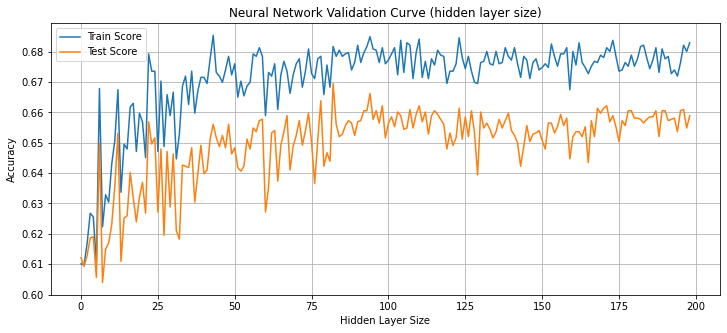

In [232]:
nn_train_scores = []
nn_cross_val_scores = []

for i in range(1,200):
    
    nn_vc = MLPClassifier(solver='sgd', max_iter=200, hidden_layer_sizes = i, random_state=42)
    nn_vc.fit(X_train,y_train)
    
    nn_train_scores.append(nn_vc.score(X_train,y_train))
    nn_cross_val_scores.append(cross_val_score(nn_vc, X_train,y_train, cv=cv).mean())

plt.figure(figsize=(12,5))
plt.title("Neural Network Validation Curve (hidden layer size)")
plt.xlabel("Hidden Layer Size")
plt.ylabel("Accuracy")
plt.plot(nn_train_scores,marker='',label='Train Score')
plt.plot(nn_cross_val_scores,marker='',label='Test Score')
plt.grid()
plt.legend(loc="best")

In [238]:
nn_max_test_score = max(nn_cross_val_scores)
nn_test_scores_ind = [i for i, v in enumerate(nn_cross_val_scores) if v == nn_max_test_score]
print('Max test score {} % and Hidden Layer Size = {}'.format(nn_max_test_score*100,list(map(lambda x: x+1, nn_test_scores_ind))))

Max test score 66.95097113903928 % and Hidden Layer Size = [83]


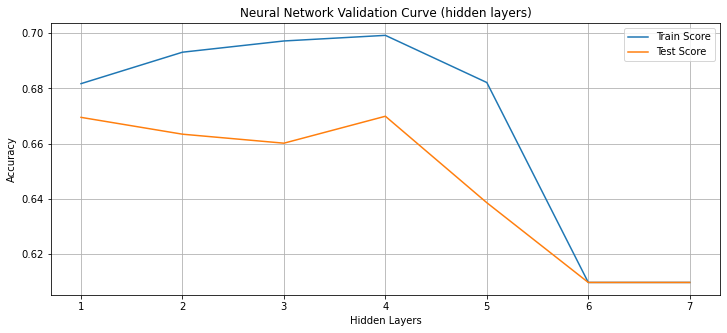

In [241]:
nn_nl_train_scores = []
nn_nl_cross_val_scores = []

layers = [[83], [83,83], [83,83,83], [83,83,83,83], [83,83,83,83,83], [83,83,83,83,83,83],[83,83,83,83,83,83,83]]

for i in layers:
    
    nn_nl = MLPClassifier(solver='sgd', max_iter=200, hidden_layer_sizes = i, random_state=42)
    nn_nl.fit(X_train,y_train)
    
    nn_nl_train_scores.append(nn_nl.score(X_train,y_train))
    nn_nl_cross_val_scores.append(cross_val_score(nn_nl, X_train,y_train, cv=cv).mean())

plt.figure(figsize=(12,5))
plt.title("Neural Network Validation Curve (hidden layers)")
plt.xlabel("Hidden Layers")
plt.ylabel("Accuracy")
plt.plot(range(1, 8),nn_nl_train_scores,marker='',label='Train Score')
plt.plot(range(1, 8),nn_nl_cross_val_scores,marker='',label='Test Score')
plt.grid()
plt.legend(loc="best")

In [242]:
nn_nl_max_test_score = max(nn_nl_cross_val_scores)
nn_nl_test_scores_ind = [i for i, v in enumerate(nn_nl_cross_val_scores) if v == nn_nl_max_test_score]
print('Max test score {} % and Hidden Layers = {}'.format(nn_nl_max_test_score*100,list(map(lambda x: x+1, nn_nl_test_scores_ind))))

Max test score 66.99145596343946 % and Hidden Layers = [4]


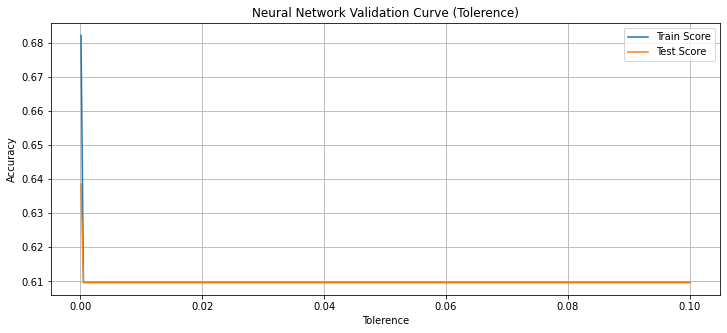

In [246]:
nn_tol_train_scores = []
nn_tol_cross_val_scores = []

tol_list = [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.05, 0.1]

for i in tol_list:
    
    nn_tol = MLPClassifier(solver='sgd', max_iter=200, tol = i, hidden_layer_sizes = tuple([83,83,83,83,83]), random_state=42)
    nn_tol.fit(X_train,y_train)
    
    nn_tol_train_scores.append(nn_tol.score(X_train,y_train))
    nn_tol_cross_val_scores.append(cross_val_score(nn_tol, X_train,y_train, cv=cv).mean())

plt.figure(figsize=(12,5))
plt.title("Neural Network Validation Curve (Tolerence)")
plt.xlabel("Tolerence")
plt.ylabel("Accuracy")
plt.plot([0.0001, 0.0005, 0.001, 0.005, 0.01, 0.05, 0.1],nn_tol_train_scores,marker='',label='Train Score')
plt.plot([0.0001, 0.0005, 0.001, 0.005, 0.01, 0.05, 0.1],nn_tol_cross_val_scores,marker='',label='Test Score')
plt.grid()
plt.legend(loc="best")

In [247]:
nn_tol_max_test_score = max(nn_tol_cross_val_scores)
nn_tol_test_scores_ind = [i for i, v in enumerate(nn_tol_cross_val_scores) if v == nn_tol_max_test_score]
print('Max test score {} % and tol = {}'.format(nn_tol_max_test_score*100,list(map(lambda x: x+1, nn_tol_test_scores_ind))))

Max test score 63.857649065289024 % and tol = [1]


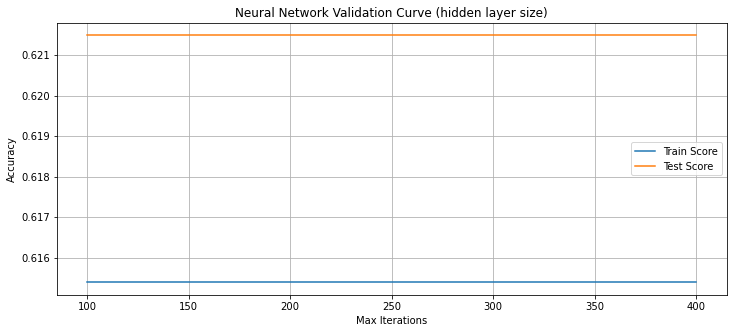

In [226]:
nni_train_scores = []
nni_cross_val_scores = []

for i in range(100,401,25):
    
    nni_vc = MLPClassifier(solver='sgd', max_iter=i, hidden_layer_sizes = 3, activation='logistic', random_state=42, tol = 0.001)
    nni_vc.fit(X_train,y_train)
    
    nni_train_scores.append(nni_vc.score(X_train,y_train))
    nni_cross_val_scores.append(cross_val_score(nni_vc, X_train,y_train, cv=cv).mean())

plt.figure(figsize=(12,5))
plt.title("Neural Network Validation Curve (hidden layer size)")
plt.xlabel("Max Iterations")
plt.ylabel("Accuracy")
plt.plot(range(100,401,25),nni_train_scores,marker='',label='Train Score')
plt.plot(range(100,401,25),nni_cross_val_scores,marker='',label='Test Score')
plt.grid()
plt.legend(loc="best")

In [248]:
nn_final = MLPClassifier(solver='sgd', max_iter=200, hidden_layer_sizes = tuple([83,83,83,83,83]), random_state=42)
nn_final.fit(X_train,y_train)
y_pred_nn_final=nn_final.predict(X_val)
score = nn_final.score(X_val, y_val)

print(score)

0.6617826617826618
